In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dscribe.descriptors import SOAP 
from sklearn.metrics import r2_score #optional
from KernelFunctions import *
from MoleculeClasses import *

## Load data
Only 100 training and testing examples for expediency

In [2]:
trainingSetSize = 100
testingSetSize = 100

alpha = Polarizability(np.load('alpha_MDA.npy')[:trainingSetSize,:,:])
geom = np.load('coord_MDA.npy')[:trainingSetSize,:,:]

alpha_test = Polarizability(np.load('alpha_MDA_test.npy')[:testingSetSize,:,:])
geom_test = np.load('coord_MDA_test.npy')[:testingSetSize,:,:]

We next split the polarizabilities into isotropic and anisotropic components

In [3]:
iso, aniso = alpha.process_alpha()
iso_test, aniso_test = alpha_test.process_alpha()

## ML representations

Below, we define the representation for ML and define the bonds that will be used in ML

In [4]:
species = ["H", "C", "O"]
r_cut = 6.0
n_max = 6
l_max = 4

soap = SOAP(species=species, periodic=False,
    r_cut=r_cut, n_max=n_max, l_max=l_max)

# List includes both O-H bonds in MDA
bonds = [[0, 1], [0, 2], [0, 5], [1, 3], [1, 7], [3, 4], [3, 8], [4, 6], [2, 6]]

We next create the training and testing sets and obtain the corresponding features

In [5]:
training_set = Molecules('CCOCOHHHH',geom)
testing_set = Molecules('CCOCOHHHH',geom_test)

In [6]:
train_features, train_RR = training_set.get_bond_features(soap,bonds,Nfeatures=855)
test_features, test_RR = testing_set.get_bond_features(soap,bonds,Nfeatures=855)

## Machine Learning
### Isotropic part

We first machine learn (get the weights) for the isotropic part

In [7]:
gamma = 1e-5 

weights_iso = get_scalar_weights(train_features,iso,gamma)

We can then predict and assess the isotropic polarizability for the testing set

In [8]:
scalarKernel = get_scalar_kernel(test_features,train_features,gamma)

iso_predicted = scalarKernel @ weights_iso

RMSE = 0.08959217190310693 a.u.
R2 = 0.9829950742378707


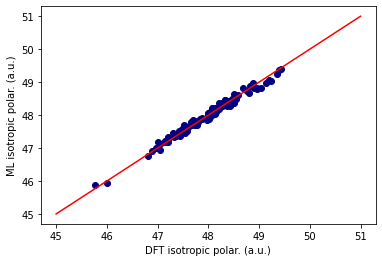

In [9]:
plt.scatter(iso_test,iso_predicted,color='navy')
plt.plot([45,51],[45,51],color='red')

plt.xlabel('DFT isotropic polar. (a.u.)')
plt.ylabel('ML isotropic polar. (a.u.)')


print(f'RMSE = {rmse(iso_test,iso_predicted)} a.u.')
print(f'R2 = {r2_score(iso_test,iso_predicted)}')

### Anisotropic part
We next repeat it for the anisotropic components. We first get the weights:

In [10]:
weights_aniso = get_tensor_weights(train_features,np.reshape(aniso,(trainingSetSize,9)),gamma,train_RR)


We then predict the {xx,yy,zz,xy,xz,yz} components of the tensor on the training set

In [11]:
beta_predicted = np.zeros((testingSetSize,6))
q_list = [0,1,2,4,5,8]

for kk, www in enumerate(q_list):

    anisotropicKernel = get_tensor_kernel(test_features,train_features, test_RR[:,www,:],gamma)
    
    predicted = anisotropicKernel @ weights_aniso
    beta_predicted[:,kk] = predicted[:,0]


And compare them to the DFT values

RMSE (β$_{xx}$) = 0.7140457213712686 a.u.
RMSE (β$_{xy}$) = 0.6278019105635693 a.u.
RMSE (β$_{xz}$) = 0.8626834526355532 a.u.
RMSE (β$_{yy}$) = 0.7463293333947315 a.u.
RMSE (β$_{yz}$) = 0.6587457669848422 a.u.
RMSE (β$_{zz}$) = 0.852781965868438 a.u.


Text(0, 0.5, 'ML β components (a.u.)')

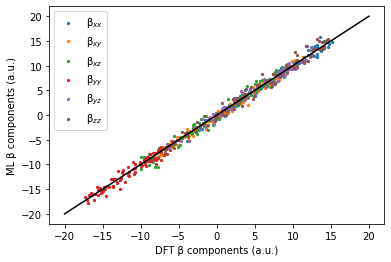

In [12]:
labels = ['β$_{xx}$','β$_{xy}$','β$_{xz}$','β$_{yy}$','β$_{yz}$','β$_{zz}$']   


dft_aniso = np.reshape(aniso_test,(testingSetSize,9))

for jjk in range(6):
    
    plt.scatter(dft_aniso[:,q_list[jjk]],beta_predicted[:,jjk],label=labels[jjk],s=5)
    rmse_ = rmse(dft_aniso[:,q_list[jjk]],beta_predicted[:,jjk])
    print('RMSE (' + labels[jjk] + ') = ' +  str(rmse_) +  ' a.u.')

plt.plot([-20,20],[-20,20],color='black')
plt.legend()

plt.xlabel('DFT β components (a.u.)')
plt.ylabel('ML β components (a.u.)')